# Imports

In [54]:
#preprocessing imports
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [55]:
# Model imports
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

from torchsummary import summary

In [56]:
#Training imports
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
from itertools import product
import sys

In [57]:
#Training visualization imports
import cv2

In [58]:
#Test imports
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import os
import random

# Preprocessing and data augmentation

In [59]:
# -----------------------
# Define Paths
# -----------------------
image_path = "/kaggle/input/brain-tumor-segmentation/images"
mask_path = "/kaggle/input/brain-tumor-segmentation/masks"

# Create Train-Val-Test Split
images = sorted(os.listdir(image_path))
masks = sorted(os.listdir(mask_path))

train_imgs, test_imgs, train_masks, test_masks = train_test_split(images, masks, test_size=0.3, random_state=42)
val_imgs, test_imgs, val_masks, test_masks = train_test_split(test_imgs, test_masks, test_size=0.5, random_state=42)

print("No of train images = ",len(train_imgs))
print("No of validation images = ",len(val_imgs))
print("No of test images = ",len(test_imgs))
# -----------------------
# Define Augmentations
# -----------------------
train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomResizedCrop(size=(512,512), scale=(0.9, 1.0), ratio=(1.0, 1.0)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor()
])

val_test_transform = transforms.Compose([
    transforms.Resize((512,512)),
    transforms.ToTensor()
])

# -----------------------
# Custom Dataset Class with Synchronized Augmentations
# -----------------------
class BrainTumorDataset(Dataset):
    def __init__(self, image_files, mask_files, img_dir, mask_dir, transform=None, num_aug=5):
        self.image_files = image_files
        self.mask_files = mask_files
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.num_aug = num_aug  # Number of augmentations per image

    def __len__(self):
        return len(self.image_files) * (self.num_aug + 1)  # Original + augmented versions

    def __getitem__(self, idx):
        original_idx = idx // (self.num_aug + 1)  # Get corresponding original image index
        aug_idx = idx % (self.num_aug + 1)  # Get augmentation number
        
        img_path = os.path.join(self.img_dir, self.image_files[original_idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[original_idx])

        image = Image.open(img_path).convert("L")
        mask = Image.open(mask_path).convert("L")

        if aug_idx == 0:
            image = val_test_transform(image)
            mask = val_test_transform(mask)
        else:
            seed = torch.randint(0, 10000, (1,)).item()  # Ensure same seed for both transformations
            torch.manual_seed(seed)
            image = self.transform(image)
            torch.manual_seed(seed)
            mask = self.transform(mask)

        return image, mask

    def show_sample(self, idx):
        """Display original and 5 augmented versions of an image-mask pair."""
        original_idx = idx // (self.num_aug + 1)  # Get corresponding original index
        
        fig, axes = plt.subplots(2, self.num_aug + 1, figsize=(15, 6))
        titles = ["Original Image"] + [f"Augmented {i}" for i in range(1, self.num_aug + 1)]
        
        for aug_idx in range(self.num_aug + 1):
            sample_img, sample_mask = self.__getitem__(original_idx * (self.num_aug + 1) + aug_idx)
            
            sample_img = sample_img.squeeze().numpy()
            sample_mask = sample_mask.squeeze().numpy()
            
            axes[0, aug_idx].imshow(sample_img, cmap='gray')
            axes[0, aug_idx].set_title(titles[aug_idx])
            axes[0, aug_idx].axis("off")
            
            axes[1, aug_idx].imshow(sample_mask, cmap='gray')
            axes[1, aug_idx].set_title(titles[aug_idx])
            axes[1, aug_idx].axis("off")

        plt.suptitle("Original & Augmented Images and Masks")
        plt.show()

# -----------------------
# Create Dataset Objects
# -----------------------
train_dataset = BrainTumorDataset(train_imgs, train_masks, image_path, mask_path, transform=train_transform, num_aug=5)
val_dataset = BrainTumorDataset(val_imgs, val_masks, image_path, mask_path, transform=None, num_aug=0)  # No augmentation for validation
test_dataset = BrainTumorDataset(test_imgs, test_masks, image_path, mask_path, transform=None, num_aug=0)  # No augmentation for test

# -----------------------
# Create DataLoaders
# -----------------------
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

# -----------------------
# Verify DataLoader
# -----------------------
for images, masks in train_loader:
    print("Image batch shape:", images.shape)  # (batch_size, 1, 512, 512) # 1 is the number of channels
    print("Mask batch shape:", masks.shape)  # (batch_size, 1, 512, 512)
    print("Image min pixel value:", images.min().item())  # Should be 0.0
    print("Image max pixel value:", images.max().item())  # Should be 1.0
    print("Mask min pixel value:", masks.min().item())  # Should be 0.0
    print("Mask max pixel value:", masks.max().item())  # Should be 1.0
    break


No of train images =  2144
No of validation images =  460
No of test images =  460
Image batch shape: torch.Size([8, 1, 512, 512])
Mask batch shape: torch.Size([8, 1, 512, 512])
Image min pixel value: 0.0
Image max pixel value: 1.0
Mask min pixel value: 0.0
Mask max pixel value: 1.0


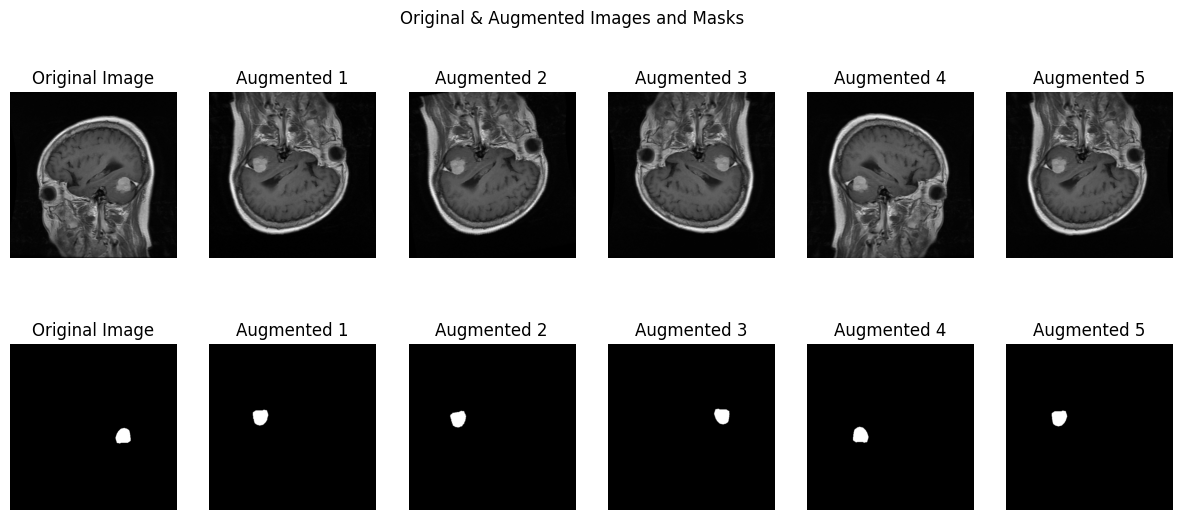

In [60]:
train_dataset.show_sample(0)

In [68]:
print("Number of images train_dataset = ", len(train_dataset))
print("Number of images in each train_dataset = ", len(train_dataset[0]))
print("Total = ",(len(train_dataset)*len(train_dataset[0])))

Number of images train_dataset =  12864
Number of images in each train_dataset =  2
Total =  25728


In [69]:
print("Number of images val_dataset = ", len(val_dataset))
print("Number of images in each val_dataset = ", len(val_dataset[0]))
print("Total = ",(len(val_dataset)*len(val_dataset[0])))

Number of images val_dataset =  460
Number of images in each val_dataset =  2
Total =  920


In [70]:
print("Number of images test_dataset = ", len(test_dataset))
print("Number of images in each test_dataset = ", len(test_dataset[0]))
print("Total = ",(len(test_dataset)*len(test_dataset[0])))

Number of images test_dataset =  460
Number of images in each test_dataset =  2
Total =  920


# Model

In [72]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

class DoubleConv(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(DoubleConv,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class UNET(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.out_channels = out_channels
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1] #reverse list

        for idx in range(0, len(self.ups), 2):  #do up and double_conv
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

def test():
    x = torch.randn((3,1, 512, 512)).to(DEVICE)
    model = UNET(in_channels=1, out_channels=1).to(DEVICE)
    preds = model(x)
    print(f"Test shape = {x.shape}")
    print(f"Prediction shape = {preds.shape}")
    summary(model, (1, 512, 512))

if __name__ == "__main__":
    test()

Test shape = torch.Size([3, 1, 512, 512])
Prediction shape = torch.Size([3, 1, 512, 512])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]             576
       BatchNorm2d-2         [-1, 64, 512, 512]             128
              ReLU-3         [-1, 64, 512, 512]               0
            Conv2d-4         [-1, 64, 512, 512]          36,864
       BatchNorm2d-5         [-1, 64, 512, 512]             128
              ReLU-6         [-1, 64, 512, 512]               0
        DoubleConv-7         [-1, 64, 512, 512]               0
         MaxPool2d-8         [-1, 64, 256, 256]               0
            Conv2d-9        [-1, 128, 256, 256]          73,728
      BatchNorm2d-10        [-1, 128, 256, 256]             256
             ReLU-11        [-1, 128, 256, 256]               0
           Conv2d-12        [-1, 128, 256, 256]         147,456
      BatchNo

# Training

In [12]:
LEARNING_RATE = 1e-4
BATCH_SIZE = 8
NUM_EPOCHS = 25
LOAD_MODEL = False
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()

            #print(f"Predictions shape: {preds.shape}, y shape: {y.shape}")
            
            num_correct += (preds == y).sum().item()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)

    print(f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}")
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()

def save_predictions_as_imgs(loader, model, folder="saved_images/", device="cuda"):
    os.makedirs(folder,exist_ok=True)
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(
            preds, f"{folder}/pred_{idx}.png"
        )
        torchvision.utils.save_image(y, f"{folder}{idx}.png")

    model.train()
    
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().to(device=DEVICE)

        # forward
        with torch.amp.autocast('cuda'):
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

def main():
    model = UNET(in_channels=1, out_channels=1).to(DEVICE)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    if LOAD_MODEL:
        load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)


    check_accuracy(val_loader, model, device=DEVICE)
    scaler = torch.amp.GradScaler()

    for epoch in range(NUM_EPOCHS):
        train_fn(train_loader, model, optimizer, loss_fn, scaler)

        # save model
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer":optimizer.state_dict(),
        }
        save_checkpoint(checkpoint)

        # check accuracy
        check_accuracy(val_loader, model, device=DEVICE)

        # print some examples to a folder
        save_predictions_as_imgs(val_loader, model, folder="saved_images/", device=DEVICE)

if __name__ == "__main__":
    main()

Got 29575683/30146560 with acc 98.11
Dice score: 0.0


  0%|          | 0/1608 [00:00<?, ?it/s]

=> Saving checkpoint
Got 29796156/30146560 with acc 98.84
Dice score: 0.6594000458717346


# Training prediction batch-wise visualization

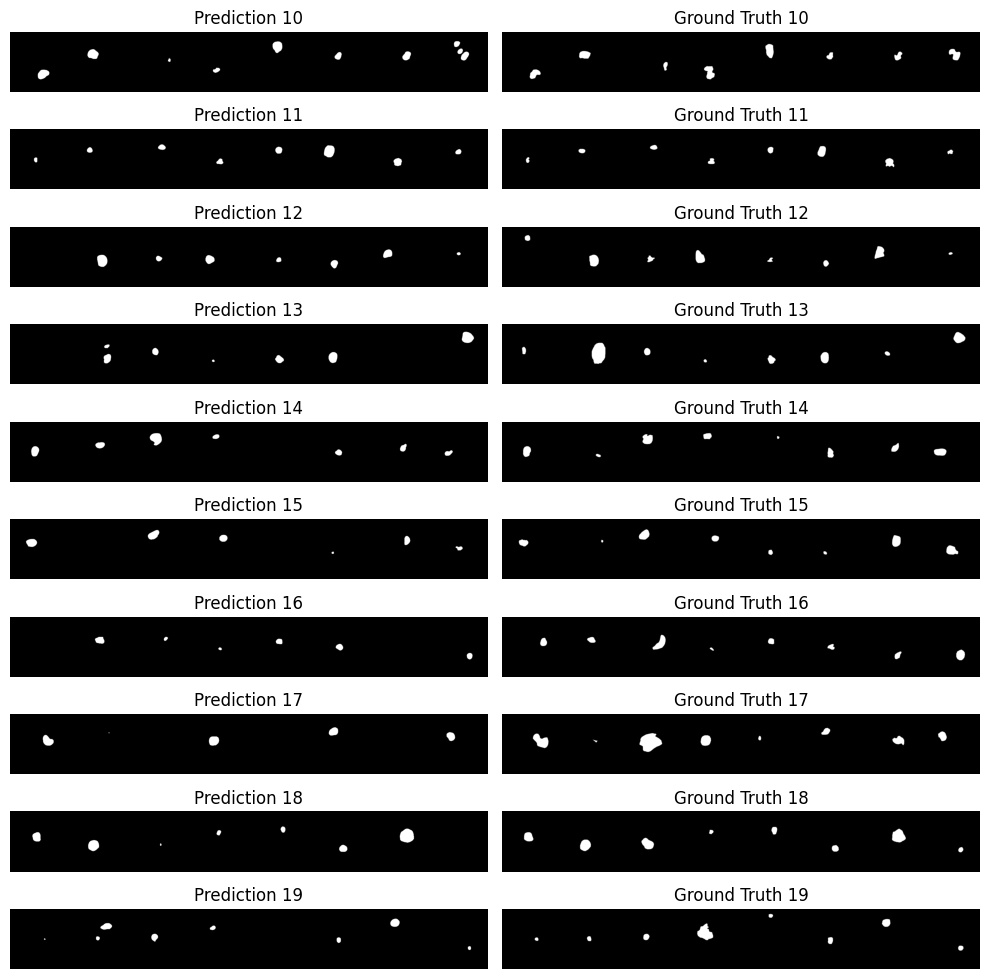

In [13]:
# Path to saved images
saved_images_path = "saved_images/"

# List all images
saved_images = sorted(os.listdir(saved_images_path))

# Display a few predictions
fig, axes = plt.subplots(10, 2, figsize=(10, 10))

for i in range(10):
    # Load prediction & corresponding ground truth
    pred_path = os.path.join(saved_images_path, f"pred_{i+10}.png")
    mask_path = os.path.join(saved_images_path, f"{i+10}.png")  # Ground truth mask

    pred_img = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)
    mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    axes[i, 0].imshow(pred_img, cmap="gray")
    axes[i, 0].set_title(f"Prediction {i+10}")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(mask_img, cmap="gray")
    axes[i, 1].set_title(f"Ground Truth {i+10}")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

# Predict any image from test dataset

In [43]:
# Load trained model
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize UNET model (Ensure UNET class is defined/imported before this)
model = UNET(in_channels=1, out_channels=1).to(DEVICE)

# Load the checkpoint from Kaggle dataset
checkpoint_path = "/kaggle/input/unet-dummy/pytorch/default/1/my_checkpoint.pth.tar"
checkpoint = torch.load(checkpoint_path, map_location=DEVICE)

# Load model state
model.load_state_dict(checkpoint["state_dict"])
model.eval()

# Define Preprocessing Transform
val_test_transform = transforms.Compose([
    transforms.Resize((512,512)),
    transforms.ToTensor()
])

def predict_single_image(img_path, mask_path, model):
    """
    Given an image path, this function returns the original image, 
    predicted mask, and ground truth mask.
    """
    # Load original image & mask
    image = Image.open(img_path).convert("L")  # Convert to grayscale
    mask = Image.open(mask_path).convert("L")  # Convert to grayscale
    
    # Transform image
    input_tensor = val_test_transform(image).unsqueeze(0).to(DEVICE)  # Add batch dimension

    # Get model prediction
    with torch.no_grad():
        pred_mask = torch.sigmoid(model(input_tensor))
        pred_mask = (pred_mask > 0.5).float()

    # Convert Tensors to Numpy
    original_np = input_tensor.cpu().squeeze().numpy()
    pred_mask_np = pred_mask.cpu().squeeze().numpy()
    mask_np = val_test_transform(mask).cpu().squeeze().numpy()

    # Plot Original Image, Predicted Mask, and Ground Truth Mask
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    titles = ["Original Image", "Predicted Mask", "Ground Truth Mask"]
    images = [original_np, pred_mask_np, mask_np]

    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap="gray")
        ax.set_title(titles[i])
        ax.axis("off")

    plt.show()

<ipython-input-43-73306e8a0343>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=DEVICE)


Testing on random image: 2311.png
Image path :  /kaggle/input/brain-tumor-segmentation/images/2311.png
Mask path :  /kaggle/input/brain-tumor-segmentation/masks/2311.png


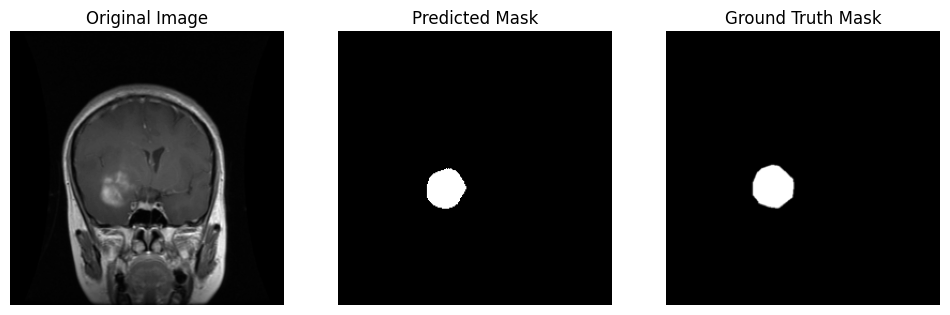

In [53]:
# -----------------------
# Test on a sample image
# -----------------------

## Choose a **random** test image and mask
rand_idx = random.randint(0, len(test_imgs) - 1)
img_name = test_imgs[rand_idx]
mask_name = test_masks[rand_idx]

# Define full paths
img_path_test = os.path.join(image_path, img_name)
mask_path_test = os.path.join(mask_path, mask_name)

print(f"Testing on random image: {img_name}")
print("Image path : ", img_path_test)
print("Mask path : ", mask_path_test)

# Run the function
predict_single_image(img_path_test, mask_path_test, model)